In [217]:
import string
import os
import re
import pandas as pd

In [218]:
pd.set_option('display.max_rows', None)
os.chdir(r"C:\Users\tmitc\notebooks\mini-project\diary") # need to make this path relative to current notebooks directory
year_1804 = []
year_1805 = []

all_entries = os.listdir()

In [219]:
for f in all_entries:
    if f.startswith('1804'):
        entry = open(f, "r")
        year_1804.append(entry.read().lower().replace('#', '').replace('$', ''))
    elif f.startswith('1805'):
        entry = open(f, "r")
        year_1805.append(entry.read().lower().replace('#', '').replace('$', ''))

In [220]:
entries_df = pd.DataFrame(year_1804, columns=["Text"])
print("")

In [221]:
entries_df['Clear'] = entries_df.Text.str.contains('clear')
entries_df['Warm'] = entries_df.Text.str.contains('warm')
entries_df['Cloudy'] = entries_df.Text.str.contains('cloud')
entries_df['Snow'] = entries_df.Text.str.contains('snow')
entries_df['Cold'] = entries_df.Text.str.contains('|'.join(['cold', 'chill', 'snow', 'cool']))
entries_df['Windy'] = entries_df.Text.str.contains('|'.join(['wind', 'blowd', 'gust', 'blowed']))
entries_df['Raining'] = entries_df.Text.str.contains('|'.join(['rain', 'shower']))
entries_df['Bad Weather'] = entries_df.Snow.astype(int) + entries_df.Raining.astype(int) + entries_df.Cold.astype(int)
entries_df['Sick Count'] = entries_df.Text.str.count('sick') + entries_df.Text.str.count('unwel') + entries_df.Text.str.count('ill')
entries_df

,Text,Clear,Warm,Cloudy,Snow,Cold,Windy,Raining,Bad Weather,Sick Count
0,"cloudy, snowd at night. mr ballard and ephraim...",False,False,True,True,True,False,False,2,3
1,clear. mr ballard is gone to ye meddow. i feel...,True,False,False,False,False,True,False,0,2
2,snowd. son lambard conducted his wife and babe...,False,False,False,True,True,False,False,2,2
3,cloudy. son lambard came and conducted his wif...,False,False,True,False,False,False,False,0,1
4,clear and cold. son pollard brot his wife & tw...,True,False,False,False,True,False,False,1,2
5,clear. daughter ballard washt here for her sel...,True,False,False,False,False,False,False,0,0
6,clear and cool. i have felt so well as to help...,True,False,False,False,True,False,False,1,0
7,clear. rachel town to meeting afternoon and di...,True,False,False,False,False,False,False,0,0
8,snow storm. son pollard came with a covered sl...,False,False,False,True,True,False,False,2,0
9,cloudy. haman burr conducted rachel town from ...,False,False,True,False,False,False,False,0,2


In [222]:
def get_weekly_totals(df):
    records = []
    for i in range(52):
        bad_weather_total = 0
        sick_total = 0
        week = i + 1
        
        for j in range(7):
            bad_weather_total += df.iloc[(i * 7) + j]['Bad Weather']
            sick_total += df.iloc[(i * 7) + j]['Sick Count']
        
        records.append([week, bad_weather_total, sick_total])
    
    return pd.DataFrame.from_records(records, columns=['Week', 'Bad Weather', 'Sick'])

weekly = get_weekly_totals(entries_df)

<AxesSubplot:>

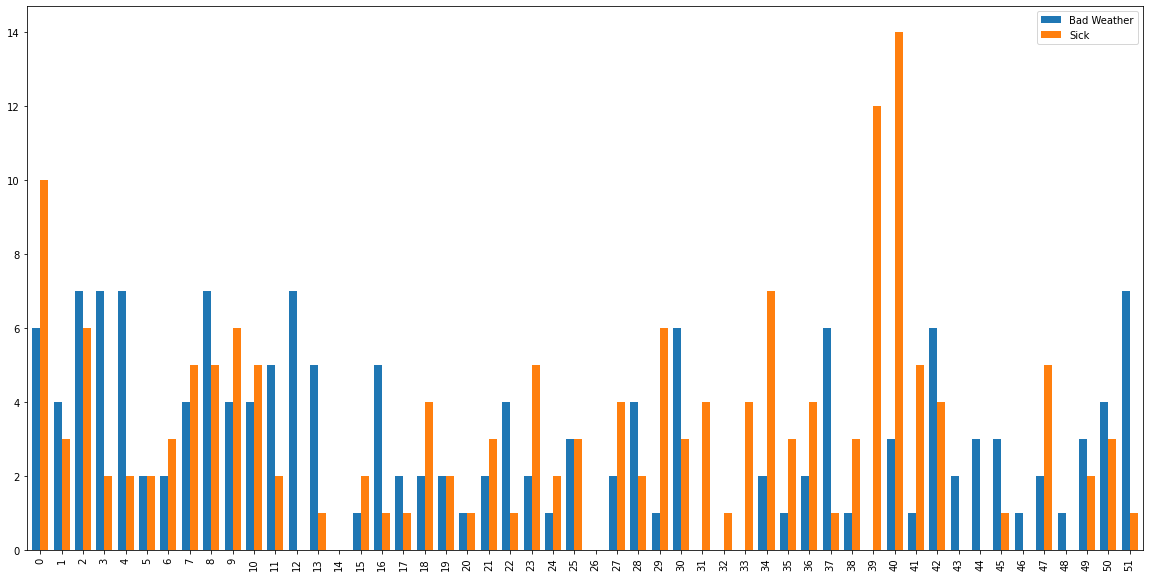

In [223]:
weekly[['Bad Weather', 'Sick']].plot(kind='bar', figsize=(20, 10), width=0.75)